<a href="https://colab.research.google.com/github/KassenBoyaubay/MPA-MLF-Exercises/blob/main/Finalproject/Finalproject_Colab_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MPA-MLF, Finalproject
### *Kassen Boyaubay*

## 0. Import libraries

In [53]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from keras.utils import to_categorical
from keras import layers, Model, Sequential, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.utils import class_weight

# from keras import regularizers
# from sklearn import preprocessing
# from sklearn.svm import LinearSVC

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Mount Files

In [2]:
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Dataset/'
x_train_dir_csv = os.path.join(base_dir, 'Train/CSV/')
x_test_dir_csv = os.path.join(base_dir, 'Test/CSV/')
y_train_dir = os.path.join(base_dir, 'y_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data examination

### 2.1 Size of the dataset

In [3]:
print('total training images:', len(os.listdir(x_train_dir_csv)))
print('total test images:', len(os.listdir(x_test_dir_csv)))

total training images: 8279
total test images: 3549


### 2.2 Explore the dataset

In [28]:
img_name = 'img_0'
img = pd.read_csv('/content/drive/MyDrive/Dataset/Train/CSV/' + img_name + '.csv').values
print('Image shape: ', img.shape)
print(img)

img = np.delete(img, 0, 1)
print('Image shape without first column: ', img.shape)
print(img)

Image shape:  (44, 52)
[[  0.      40.809   25.751  ... 104.78    51.486    7.3866]
 [  1.      35.794   24.56   ...  79.366   56.694   63.145 ]
 [  2.      16.8     14.145  ...  31.332   24.686   21.428 ]
 ...
 [ 41.      62.486   74.848  ...  23.319   59.134   64.447 ]
 [ 42.      11.689   13.603  ...  22.591   43.078   32.451 ]
 [ 43.      80.212   27.695  ...  60.717   30.785   82.938 ]]
Image shape without first column:  (44, 51)
[[ 40.809   25.751   89.378  ... 104.78    51.486    7.3866]
 [ 35.794   24.56    37.289  ...  79.366   56.694   63.145 ]
 [ 16.8     14.145   51.555  ...  31.332   24.686   21.428 ]
 ...
 [ 62.486   74.848   41.44   ...  23.319   59.134   64.447 ]
 [ 11.689   13.603   60.658  ...  22.591   43.078   32.451 ]
 [ 80.212   27.695   17.801  ...  60.717   30.785   82.938 ]]


Text(0.5, 1.0, 'img_0')

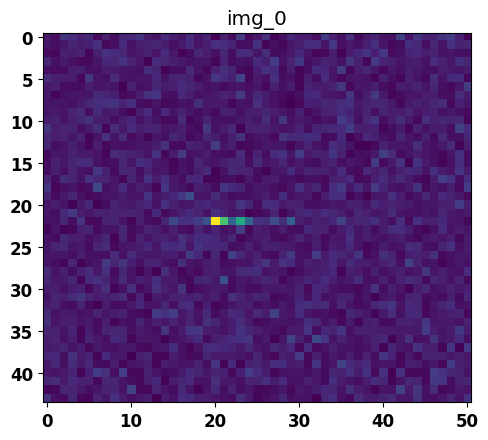

In [29]:
plt.imshow(img)
plt.title(img_name)

### 2.3 Explore the labels

In [6]:
y_train = pd.read_csv(y_train_dir)
print(y_train.iloc[0:4])
print('y_train shape:', y_train.shape)
print('\ny_train unique values:', y_train['target'].unique())
print('labels:', len(y_train['target'].unique()))

   id  target
0   0       1
1   1       3
2   2       1
3   3       1
y_train shape: (8279, 2)

y_train unique values: [1 3 2]
labels: 3


## 3. Data preprocessing

### 3.1 x_train preprocessing

In [7]:
x_train = []
for filename in os.listdir(x_train_dir_csv):
  a = pd.read_csv(os.path.join(x_train_dir_csv, filename)).values
  a = np.delete(a, 0, 1)
  x_train.append(a)
x_train = np.array(x_train)
print(x_train.shape)

(8279, 44, 51)


#### Save x_train

In [8]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_train_csv.npz', x_train)

#### Load x_train

In [37]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_train_csv.npz')
# extract the first array
x_train = dict_data['arr_0']

### 3.2 x_test preprocessing

In [10]:
x_test = []
for filename in os.listdir(x_test_dir_csv):
  a = pd.read_csv(os.path.join(x_test_dir_csv, filename)).values
  a = np.delete(a, 0, 1)
  x_test.append(a)
x_test = np.array(x_test)
print(x_test.shape)

(3549, 44, 51)


#### Save x_test

In [11]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_test_csv.npz', x_test)

#### Load x_test

In [38]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_test_csv.npz')
# extract the first array
x_test = dict_data['arr_0']

#### 3.3 Normalize x_train and x_test

In [39]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [14]:
x_train = x_train/x_train.max()
x_test = x_test/x_test.max()

OR

In [40]:
Xscaler = MinMaxScaler()
for id, (x_train_data, x_test_data) in enumerate(zip(x_train, x_test)):
  x_train_scaled=Xscaler.fit_transform(x_train_data)
  x_test_scaled=Xscaler.fit_transform(x_test_data)
  x_train[id]=x_train_scaled
  x_test[id]=x_test_scaled

### 3.4 y_train preprocessing

In [15]:
num_classes = len(y_train['target'].unique())
y_train_encoded = to_categorical(y_train['target'].values-1, num_classes).astype('int32')
print('"target" values as an array: ', y_train['target'].values)
print('one-hot encoded y_train: \n', y_train_encoded)

"target" values as array:  [1 3 1 ... 2 1 2]
one-hot encoded: 
 [[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]


### 3.5 train test split

In [42]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train_encoded, test_size=0.2)

## 4. MLP model

### 4.1 Build MLP model

In [75]:
input_shape = (44, 51)

model = Sequential(
    [
        Input(shape=input_shape),
     
        layers.Flatten(),
     
        layers.Dense(1024, activation="relu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.2),
     
        layers.Dense(512, activation="relu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.5),
     
        # layers.Dense(128, activation="relu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.2),
     
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2244)              0         
                                                                 
 dense_14 (Dense)            (None, 1024)              2298880   
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 2,825,219
Trainable params: 2,825,219
Non-trainable params: 0
_________________________________________________________________


### 4.2 Train CNN model

In [17]:
callbacks = [
        EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=5,
        verbose=1)
]

class weights

In [68]:
y_integers = np.argmax(y_train_split, axis=1)
class_weights = class_weight.compute_class_weight(
                                                    class_weight = "balanced",
                                                    classes=np.unique(y_integers),
                                                    y = y_integers
                                                  )
d_class_weights = dict(enumerate(class_weights))

In [76]:
batch_size = 50
epochs = 10

optimizer = Adam(
    learning_rate=0.01,
)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train_split, y_train_split, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=2, class_weight=d_class_weights)

Epoch 1/10
106/106 - 4s - loss: 420.7620 - accuracy: 0.3547 - val_loss: 1.1038 - val_accuracy: 0.2823 - 4s/epoch - 40ms/step
Epoch 2/10
106/106 - 4s - loss: 2.1874 - accuracy: 0.3184 - val_loss: 1.0977 - val_accuracy: 0.4513 - 4s/epoch - 42ms/step
Epoch 3/10
106/106 - 3s - loss: 1.0992 - accuracy: 0.3163 - val_loss: 1.0935 - val_accuracy: 0.4513 - 3s/epoch - 29ms/step
Epoch 4/10
106/106 - 3s - loss: 1.0987 - accuracy: 0.3209 - val_loss: 1.0937 - val_accuracy: 0.4513 - 3s/epoch - 29ms/step
Epoch 5/10
106/106 - 3s - loss: 1.0984 - accuracy: 0.3649 - val_loss: 1.0996 - val_accuracy: 0.2664 - 3s/epoch - 29ms/step
Epoch 6/10
106/106 - 5s - loss: 1.0987 - accuracy: 0.2878 - val_loss: 1.0970 - val_accuracy: 0.4513 - 5s/epoch - 44ms/step
Epoch 7/10
106/106 - 3s - loss: 1.0979 - accuracy: 0.3541 - val_loss: 1.0991 - val_accuracy: 0.2823 - 3s/epoch - 29ms/step
Epoch 8/10
106/106 - 3s - loss: 1.0978 - accuracy: 0.3133 - val_loss: 1.0968 - val_accuracy: 0.2664 - 3s/epoch - 29ms/step
Epoch 9/10
106

### 4.3 Evaluate trained CNN model

In [17]:
loss, accuracy = model.evaluate(x_test_split, y_test_split, batch_size=1)
print('Accuracy: {:.2f}'.format(accuracy*100))
print('Loss: {:.2f}'.format(loss))

1656/1656 [==============================] - 13s 8ms/step - loss: 1.2281 - accuracy: 0.3605
Accuracy: 36.05
Loss: 1.23


Text(0, 0.5, 'loss')

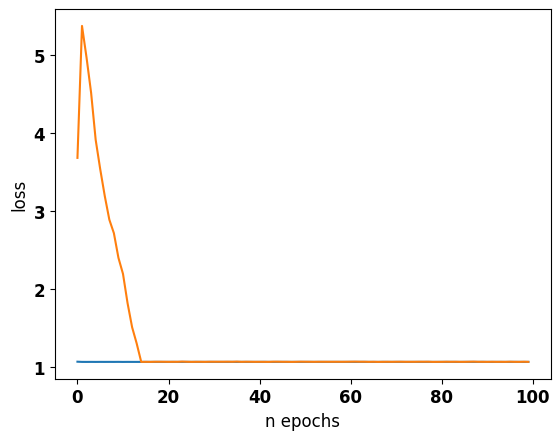

In [62]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('n epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

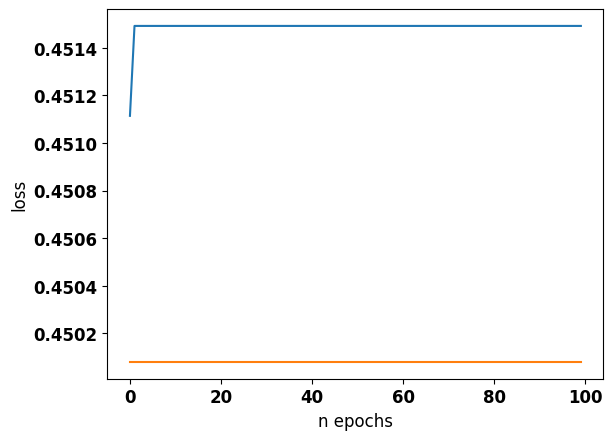

In [63]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('n epochs')
plt.ylabel('loss')

## 5. Model prediction

In [64]:
y_pred_enc = model.predict(x_test)

111/111 [==============================] - 1s 6ms/step


## 6. Export to CSV

In [66]:
indexes = argmax(y_pred_enc, axis=1)
y_pred = indexes + 1

In [ ]:
y_pred_postpr = pd.DataFrame({'id': np.arange(0, len(y_pred)), 'target': y_pred})

In [ ]:
y_pred_postpr.to_csv('y_pred_mlp.csv', index=False)